# Exploring the data

## Step 1: Import Libraries
We'll use the following libraries in this notebook:

In [16]:
import pandas as pd
import seaborn as sns
import seaborn.matrix as smatrix
import matplotlib.pyplot as plt
%matplotlib inline

## Step 2: Find highest traffic stations
First, we'll read in our cleaned dataset 

In [2]:
df = pd.read_pickle('cleaned_turnstile_data2.pkl')
df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,...,station_id,entries_diff,exit_diff,first_row_group,entires_diff,entries_outlier,exit_outlier,all_traffic,week,hour
114964,PTH07,R550,00-02-01,CITY / BUS,1,PTH,03/25/2017,07:10:33,REGULAR,22298,...,CITY / BUS1PTH,0.0,0.0,False,NaN,False,False,0.0,12,7
114965,PTH07,R550,00-02-01,CITY / BUS,1,PTH,03/25/2017,11:22:33,REGULAR,22298,...,CITY / BUS1PTH,0.0,0.0,False,NaN,False,False,0.0,12,11
114966,PTH07,R550,00-02-01,CITY / BUS,1,PTH,03/25/2017,15:34:33,REGULAR,22298,...,CITY / BUS1PTH,0.0,3.0,False,NaN,False,False,3.0,12,15
114967,PTH07,R550,00-02-01,CITY / BUS,1,PTH,03/25/2017,19:46:33,REGULAR,22298,...,CITY / BUS1PTH,0.0,1.0,False,NaN,False,False,1.0,12,19
114968,PTH07,R550,00-02-01,CITY / BUS,1,PTH,03/25/2017,23:58:33,REGULAR,22298,...,CITY / BUS1PTH,0.0,0.0,False,NaN,False,False,0.0,12,23


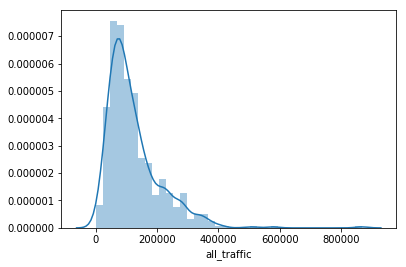

In [3]:
# Find weekly average entry/exits per station
stations_week = df.groupby(['station_id', 'week']).sum()
stations_week.reset_index(inplace=True)

weekly_avg = stations_week.groupby('station_id')['all_traffic'].mean()
weekly_avg.sort_values(ascending=False, inplace=True)

sns.distplot(weekly_avg, hist=True, kde=True);

In [4]:
weekly_avg.head()

station_id
34 ST-PENN STAACEIND       867225.533333
GRD CNTRL-42 ST4567SIRT    576730.666667
FLUSHING-MAIN7IRT          503940.933333
47-50 STS ROCKBDFMIND      411912.066667
33 ST6IRT                  396989.066667
Name: all_traffic, dtype: float64

Find the value at the bottom of the top X quantile in most trafficked stations

In [5]:
print(weekly_avg.describe())
top_Q = weekly_avg.quantile(.98)
top_Q

count       516.000000
mean     123500.020995
std       89476.300998
min         116.300000
25%       64042.933333
50%       95959.133333
75%      156802.850000
max      867225.533333
Name: all_traffic, dtype: float64


347419.3733333333

In [6]:
def find_x_most_dense_stations(series, quantile):
    largest_stations = []
    for index, value in series.iteritems():
        if value > quantile:
            largest_stations.append(index)
    return set(largest_stations)

In [7]:
most_frequent = find_x_most_dense_stations(weekly_avg, top_Q)

In [9]:
print(len(most_frequent))
most_frequent

11


{'33 ST6IRT',
 '34 ST-PENN STAACEIND',
 '47-50 STS ROCKBDFMIND',
 'CHAMBERS STACE23IND',
 'FLUSHING-MAIN7IRT',
 'FULTON ST2345ACJZIRT',
 'GRD CNTRL-42 ST4567SIRT',
 'JAY ST-METROTECACFIND',
 'JKSN HT-ROOSVLTEFMR7IND',
 'LEXINGTON AV/53EM6IND',
 'TIMES SQ-42 ST1237ACENQRSIRT'}

### Step 3: Find most active times at high traffic stations

Find the times when the frequented stations are most active

In [45]:
df['highest_freq'] = [x in most_frequent for x in df['station_id']]
highest_freq_stations = df[df['highest_freq']]
highest_freq_stations.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,...,entries_diff,exit_diff,first_row_group,entires_diff,entries_outlier,exit_outlier,all_traffic,week,hour,highest_freq
75097,N305A,R016,00-03-04,LEXINGTON AV/53,EM6,IND,03/25/2017,04:00:00,REGULAR,10500187,...,46.0,30.0,False,NaN,False,False,76.0,12,4,True
75098,N305A,R016,00-03-04,LEXINGTON AV/53,EM6,IND,03/25/2017,08:00:00,REGULAR,10500204,...,17.0,56.0,False,NaN,False,False,73.0,12,8,True
75099,N305A,R016,00-03-04,LEXINGTON AV/53,EM6,IND,03/25/2017,12:00:00,REGULAR,10500271,...,67.0,180.0,False,NaN,False,False,247.0,12,12,True
75100,N305A,R016,00-03-04,LEXINGTON AV/53,EM6,IND,03/25/2017,16:00:00,REGULAR,10500435,...,164.0,210.0,False,NaN,False,False,374.0,12,16,True
75101,N305A,R016,00-03-04,LEXINGTON AV/53,EM6,IND,03/25/2017,20:00:00,REGULAR,10500606,...,171.0,204.0,False,NaN,False,False,375.0,12,20,True


In [48]:
highest_freq_stations.reset_index(drop=True)
highest_freq_stations.to_csv('highest_freq_stations.csv', index=False)

In [54]:
# Aggregate all entry/exit counts for most frequent stations and look at distribution across days of week and hour of day
timing = highest_freq_stations.groupby(['station_id','weekday'])['all_traffic'].mean().reset_index()


In [55]:
timing.head(10)

,station_id,weekday,all_traffic
0,33 ST6IRT,Friday,308.003141
1,33 ST6IRT,Monday,272.110273
2,33 ST6IRT,Saturday,194.787946
3,33 ST6IRT,Sunday,157.358193
4,33 ST6IRT,Thursday,304.077022
5,33 ST6IRT,Tuesday,294.858494
6,33 ST6IRT,Wednesday,305.140881
7,34 ST-PENN STAACEIND,Friday,270.188473
8,34 ST-PENN STAACEIND,Monday,243.319911
9,34 ST-PENN STAACEIND,Saturday,208.426962


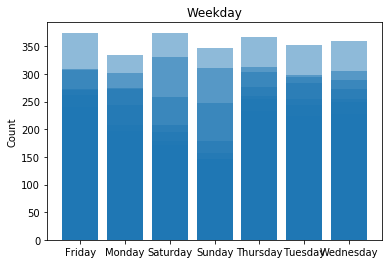

In [56]:
y = timing['all_traffic']
x = timing['weekday']

plt.bar(x, y, align='center', alpha=0.5)
plt.ylabel('Count')
plt.title('Weekday')
 
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

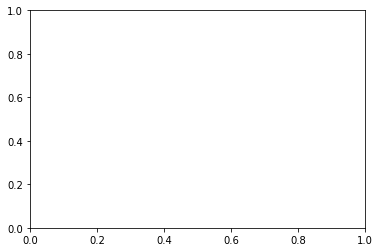

In [21]:
# Plot the station frequencies
ax = plt.subplot(111)
timing.groupby('station_id').plot(y='station_id', x='all_traffic', kind='hist', ax=ax)
#L = plt.legend()
#_ = [plt.setp(item, 'text', T) for item, T in zip(L.texts, ['2012','2013'])]
#_ = ax.set_xticks(df.ReviewDate_month.unique())

In [33]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
